In [1]:
import pandas as pd
import numpy as np
import polars as pl

In [2]:
import warnings
import scipy.stats as stats
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv("ab_data.csv")
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [5]:
# Checking for duplicates
duplicates = df.duplicated().sum()
duplicates.any()

np.False_

In [6]:
df[df["user_id"].duplicated()]

,user_id,timestamp,group,landing_page,converted
2656,698120,2017-01-15 17:13:42.602796,control,old_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0
7500,899953,2017-01-07 03:06:54.068237,control,new_page,0
8036,790934,2017-01-19 08:32:20.329057,treatment,new_page,0
10218,633793,2017-01-17 00:16:00.746561,treatment,old_page,0
...,...,...,...,...,...
294308,905197,2017-01-03 06:56:47.488231,treatment,new_page,0
294309,787083,2017-01-17 00:15:20.950723,control,old_page,0
294328,641570,2017-01-09 21:59:27.695711,control,old_page,0
294331,689637,2017-01-13 11:34:28.339532,control,new_page,0


In [7]:
df[df["user_id"]==698120]

,user_id,timestamp,group,landing_page,converted
988,698120,2017-01-22 07:09:37.540970,control,new_page,0
2656,698120,2017-01-15 17:13:42.602796,control,old_page,0


In [8]:
# Check if there's a mismatch between group and landing page
df_mismatch = df[(df["group"]=="treatment")&(df["landing_page"]=="old_page") | (df["group"]=="control")&(df["landing_page"]=="new_page")]
no_of_mismatch = df_mismatch.shape[0]
no_of_mismatch_c = df_mismatch.shape[1]
print(f"Number of mismatches rows: {no_of_mismatch} rows")
print(f"Number of mismatches columns: {no_of_mismatch_c} column")
print(f"Percent of mismatched rows:%.2f%%" % (no_of_mismatch/df.shape[0]*100))              # 3893/294478

Number of mismatches rows: 3893 rows
Number of mismatches columns: 5 column
Percent of mismatched rows:1.32%


In [9]:
df2 = df[(df["group"]=="treatment")&(df["landing_page"]=="new_page") | (df["group"]=="control")&(df["landing_page"]=="old_page")]

In [10]:
df2[df2["user_id"].duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [11]:
df2[df2["user_id"]==773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [12]:
df2.drop_duplicates(subset="user_id",inplace=True)

C:\Users\ezzel\AppData\Local\Temp\ipykernel_13456\3085027625.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2.drop_duplicates(subset="user_id",inplace=True)


In [13]:
df2.shape

(290584, 5)

In [14]:
#Conversion Rate
df_counts = pd.DataFrame({"Control_Count": df2[df2.group=="control"].converted.value_counts(),
                          "Treatment_Count": df2[df2.group=="treatment"].converted.value_counts(),
                          "Control_Ratio": df2[df2.group=="control"].converted.value_counts()/ len(df2[df2.group=="control"]),
                          "Treatment_Ratio": df2[df2.group=="treatment"].converted.value_counts() / len(df2[df2.group=="treatment"])})
df_counts

,Control_Count,Treatment_Count,Control_Ratio,Treatment_Ratio
converted,,,,
0,127785,128046,0.879614,0.881192
1,17489,17264,0.120386,0.118808


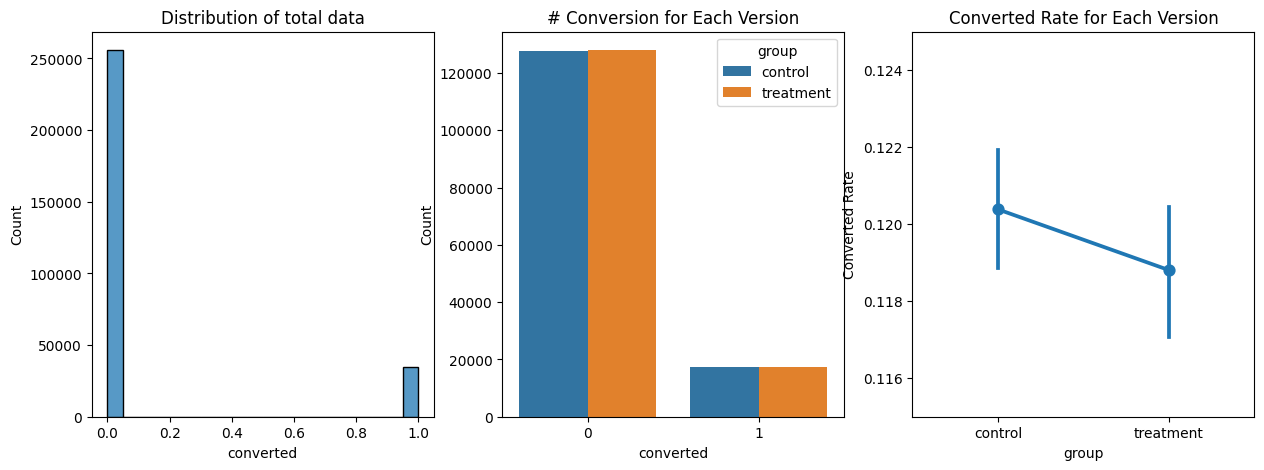

In [15]:
fig, axes = plt.subplots(1,3, figsize= (15, 5))

sns.histplot(x="converted", data=df2, ax=axes[0])
axes[0].set_title("Distribution of total data")

sns.countplot(x="converted", data=df2, hue="group", ax=axes[1])
axes[1].set(title="# Conversion for Each Version", ylabel="Count")

sns.pointplot(x="group", y="converted", data=df2, ax=axes[2])
axes[2].set_ylim([0.115, 0.125])
axes[2].set(title="Converted Rate for Each Version",ylabel="Converted Rate")

plt.show()

### H0 = Conversion Rate of Control version = Conversion Rate of treatment
### H1 = Conversion Rate of Control version != Conversion Rate of treatment

In [16]:
table = df_counts.iloc[:, 0:2].to_numpy()
table

array([[127785, 128046],
       [ 17489,  17264]])

In [17]:
# Chi-squared test
stat, p, dof, expected = stats.chi2_contingency(table)
print("Freedom of degree=%d"% dof)
print(expected)

# interpret test-statistic
prob = 0.95
critical = stats.chi2.ppf(prob, dof)
print("probability=%.3f, critical=%.3f, stat=%.3f" % (prob, critical, stat))
if abs(stat) >= critical:
    print("Dependent (reject H0)")
else:
    print("Independent (fail to reject H0)")

# Interpret p-value
alpha = 1-prob
print("significance=%.3f, p=%.3f" % (alpha, p))
if p <= alpha:
    print("Dependent (reject H0)")
else:
    print("Independent (fail to reject H0)")

Freedom of degree=1
[[127899.65274757 127931.34725243]
 [ 17374.34725243  17378.65274757]]
probability=0.950, critical=3.841, stat=1.704
Independent (fail to reject H0)
significance=0.050, p=0.192
Independent (fail to reject H0)


In [18]:
# Fishers exact test on data
odd_ratio, p_value = stats.fisher_exact(table=table, alternative="two-sided")
print("odd ratio is: " + str(odd_ratio))
print("p_value is: " + str(p_value))
if p_value <= alpha:
    print("Dependent (reject H0)")
else:
    print("Independent (fail to reject H0) ")

odd ratio is: 0.9851226640350362
p_value is: 0.19047706765708894
Independent (fail to reject H0) 


In [19]:
def ab_testing(dataframe, group ,metric):
    
    group_c = dataframe[dataframe[group] == "control"][metric]
    group_t = dataframe[dataframe[group] == "treatment"][metric]

    size = dataframe.shape[0]
    table = pd.DataFrame({"C_Count": group_c.value_counts(),
                          "T_Count": group_t.value_counts()}).to_numpy()
    
    if size < 1000:
        #Fisher exact test
        odd_ratio, p_value = stats.fisher_exact(table, alternative="two-sided")
    else:
        # Person Chi Square test
        stat, p_value, dof, expected = stats.chi2_contingency(table)
    
    # Result df
    temp = pd.DataFrame({
        "Test":[size<1000],
        "P_value":[p_value],
        "AB Hypothesis": [p_value < 0.05],
    })
    
    temp["Test"] = np.where(temp["Test"]==True, "Fisher Exact Test", "Chi squared Test")
    temp["AB Hypothesis"] = np.where(temp["AB Hypothesis"] == False, "Fail to reject H0", "Reject H0")
    temp["Comment"] = np.where(temp["AB Hypothesis"] == "Fail to reject H0", "A/B Groups are similar", "A/B Groups are not similar")

    return temp

# Apply AB Testing
ab_testing(dataframe=df2, group="group", metric="converted")

,Test,P_value,AB Hypothesis,Comment
0,Chi squared Test,0.191822,Fail to reject H0,A/B Groups are similar
